# Simulation of the Entry, Working and Final Trajectory at Saturn - V1

This notebook will simualate and demonstrate the 1st feasible solution of the maneuvers performed in order to...
* ... entry the Sphere of Influence (SOI) of Saturn,
* ... being captured by Saturn,
* ... getting into the desired working trajectory around Saturn,
* ... and safely deorbit the S/C.

To execute this notebook, you have to follow the instructions given in the README.md file of this repository and use the same Python virtual environment as for the interplanetary trajectory optimization.

The only difference to the 1st version is how the S/C will be deorbited. This will result in a different $\Delta v$ and therefore to another final mass of propellant. This has to be considered when choosing the launcher.

In [1]:
# Import required packages for the entire notebook

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time

from poliastro.bodies import Saturn
from poliastro.twobody import Orbit
from poliastro.plotting.static import StaticOrbitPlotter
from poliastro.threebody.flybys import compute_flyby
from poliastro.plotting.static import StaticOrbitPlotter
from poliastro.plotting import OrbitPlotter3D

## Entering the SOI of Saturn

After arriving at Saturn as computed in the interplanetary trajectory optimization, the S/C will perform a small maneuver to increase the impact parameter $b$ (semi-minor axis) of the hyperbolic entry orbit around Saturn. The value of $b$ is set in a way, that the perigee lies within the F and the G ring of Saturn.

We are assuming that the rings are in the ideal position 

In [2]:
# Define the v_inf (-> computed by interplanetary trajectory optimization)
v_inf = 9.944993828291523 * (u.km / u.s)

entry_time = Time("2041-09-14", scale="tdb")

# Define the impact parameter b which results in a perigee of about 150 000 km
distance_b = 370000 * u.km

# Get standard gravitational constant of Saturn in correct units
mu = Saturn.k.to(u.km**3 / u.s**2)

# Calculate semi-major axis of hyperbolic orbit
a_entry = -mu / v_inf**2

# Calculate eccentricity of hyperbolic orbit
e_entry = (1 + (distance_b**2 / a_entry**2))**0.5

# Inclination due to tilt angle of Saturn with respect to ecliptic plane
inc_entry = 26.73 * u.deg

# Initialize the hyperbolic entry orbit in SOI of Saturn
orbit_entry = Orbit.from_classical(Saturn, a_entry, e_entry, inc_entry, 0 * u.deg, 0 * u.deg, 0 * u.rad, entry_time)

# Calculate the velocity of the S/C at the perigee
v_perigee_entry = np.sqrt(mu * ((2 / (orbit_entry.r_p)) - (1 / orbit_entry.a)))

# Print results and orbit parameters
print("Results of the Entry Orbit:")
print(f"Radius of Perigee:\t\t{orbit_entry.r_p}")
print(f"Velocity at Perigee:\t\t{v_perigee_entry}")


Results of the Entry Orbit:
Radius of Perigee:		149384.95513004728 km
Velocity at Perigee:		24.631983276124032 km / s


#### 2D Plot of the hyperbolic entry trajectory

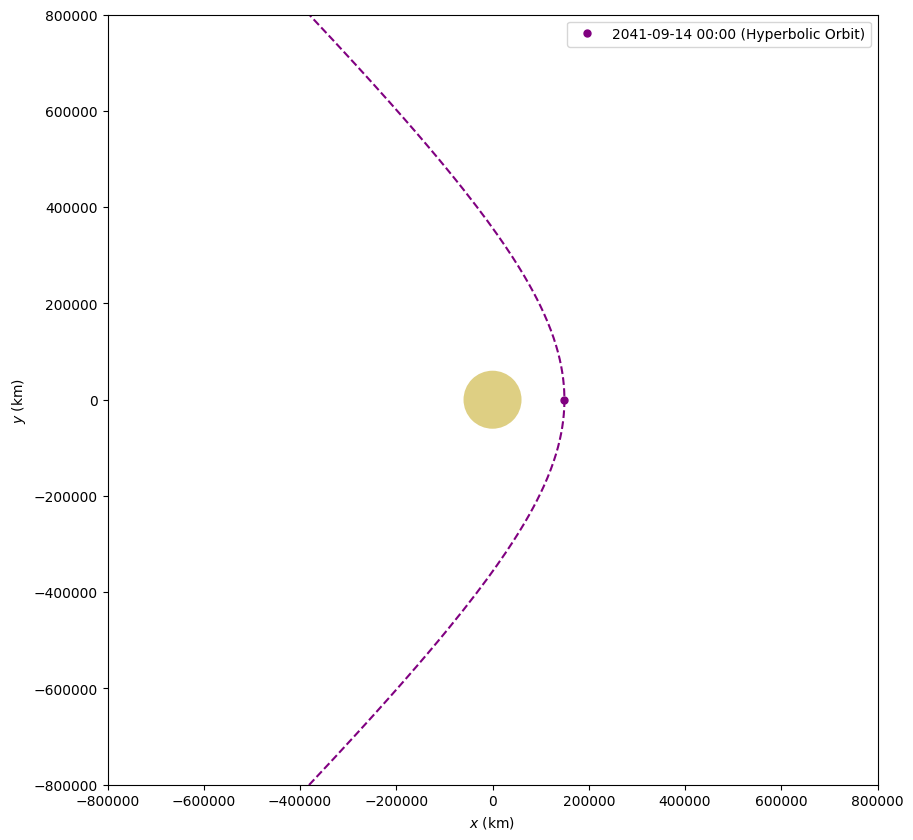

In [3]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
lim = 800000
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
plotter = StaticOrbitPlotter(ax)
plotter.plot(orbit_entry, label="Hyperbolic Orbit", color='purple')

# Show plot with legend
ax.legend()
plt.show()

The first maneuver is then performed at the perigee. A $\Delta v_{1}$ is applied in the negative flight direction in order to decrease the velocity. The magnitude of $\Delta v_{1}$ is chosen so that the the resulting orbit has a very high eccentricity of about $0.98$.

Using the formula:
$\newline e = \frac{r_a - r_p}{r_a + r_p} \rightarrow r_a = \frac{-r_p - r_p \cdot e}{e - 1}$

In [4]:
# Calculate the distance of the apogee
e_1 = 0.98 * u.one
r_perigee_1 = orbit_entry.r_p.to(u.km)
r_apogee_1 = (-r_perigee_1 - r_perigee_1 * e_1) / (e_1 - 1)

# Calculate desired semi-major axis
semi_major_1 = (r_perigee_1 + r_apogee_1) * 0.5

# Calculate velocities at apogee and perigee of desired orbit
v_perigee_1 = np.sqrt(mu * ( (2 / (r_perigee_1)) - (1 / semi_major_1) ) )
v_apogee_1 = np.sqrt(mu * ( (2 / (r_apogee_1)) - (1 / semi_major_1) ) )

# Calculate the delta v
delta_v_1 = np.abs(v_perigee_1 - v_perigee_entry)

# Print results
print(f"Distance of perigee of first orbit:\t\t{r_perigee_1}")
print(f"Distance of apogee of first orbit:\t\t{r_apogee_1}")

print(f"Velocity of perigee of first orbit:\t\t{v_perigee_1}")
print(f"Velocity of apogee of first orbit:\t\t{v_apogee_1}")

print(f"\n1st Delta V applied at perigee:\t\t\t{delta_v_1}")

Distance of perigee of first orbit:		149384.95513004728 km
Distance of apogee of first orbit:		14789110.557874668 km
Velocity of perigee of first orbit:		22.422162716646948 km / s
Velocity of apogee of first orbit:		0.22648649208734342 km / s

1st Delta V applied at perigee:			2.209820559477084 km / s


Now the S/C is captured on a high eccentric orbit around Saturn. We now want to increase the inclination to a desired value of $90\deg$ and want to achieve a circular orbit with radius between $500 000$ km to $600 000$ km to be outside of the rings but still being close enough to Saturn to be able to take high quality image data.

To get in such an orbit without needing to much $\Delta v$, we first increase the inclination of the current orbit to $62\deg$ and change the distance of the perigee to the distance of the Titan moon and Saturn. In this way we ensure that we will meet Titan at the perigee to be able to perform a flyby maneuver.

Both is achieved with one maneuver by applying the required $\Delta v_2$ at the apogee of the highly eccentric orbit, because an inclination change highly depends on the current velocity of the S/C.

The formula for computing the required $\Delta v_2$:
$\newline \Delta v_2 = v_1^2 \cdot v_2^2 - 2 \cdot v_1 \cdot v_2 \cdot \cos{\Delta i}$

In [5]:
r_titan_saturn = 1221870 * u.km

# Define new orbit parameters
r_perigee_2 = r_titan_saturn
r_apogee_2 = r_apogee_1
semi_major_2 = (r_perigee_2 + r_apogee_2) / 2.

# Calucalte velocities of new orbit
v_perigee_2 = np.sqrt(mu * ( (2 / (r_perigee_2)) - (1 / semi_major_2)))
v_apogee_2 = np.sqrt(mu * ( (2 / (r_apogee_2)) - (1 / semi_major_2)))

delta_inc = 62 * u.deg - orbit_entry.inc.to(u.deg)
v_1 = v_apogee_1
v_2 = v_apogee_2

# Calculate required delta v
delta_v_2 = np.sqrt( v_1**2 + v_2**2 - 2  * v_1 * v_2 * np.cos(delta_inc.to(u.rad)))

# Assign orbit parameters of 2nd orbit
inc_2 = 62 * u.deg
e_2 = (r_apogee_2 - r_perigee_2) / (r_apogee_2 + r_perigee_2)

# Print results
print(f"Distance of perigee of second orbit:\t\t{r_perigee_2}")
print(f"Distance of apogee of second orbit:\t\t{r_apogee_2}")

print(f"Velocity of perigee of second orbit:\t\t{v_perigee_2}")
print(f"Velocity of apogee of second orbit:\t\t{v_apogee_2}")

print(f"\n2nd Delta V applied at apogee:\t\t\t{delta_v_2}")

Distance of perigee of second orbit:		1221870.0 km
Distance of apogee of second orbit:		14789110.557874668 km
Velocity of perigee of second orbit:		7.572911732387974 km / s
Velocity of apogee of second orbit:		0.6256707340338283 km / s

2nd Delta V applied at apogee:			0.45975117426566875 km / s


#### Plot of the 1st and 2nd Orbit

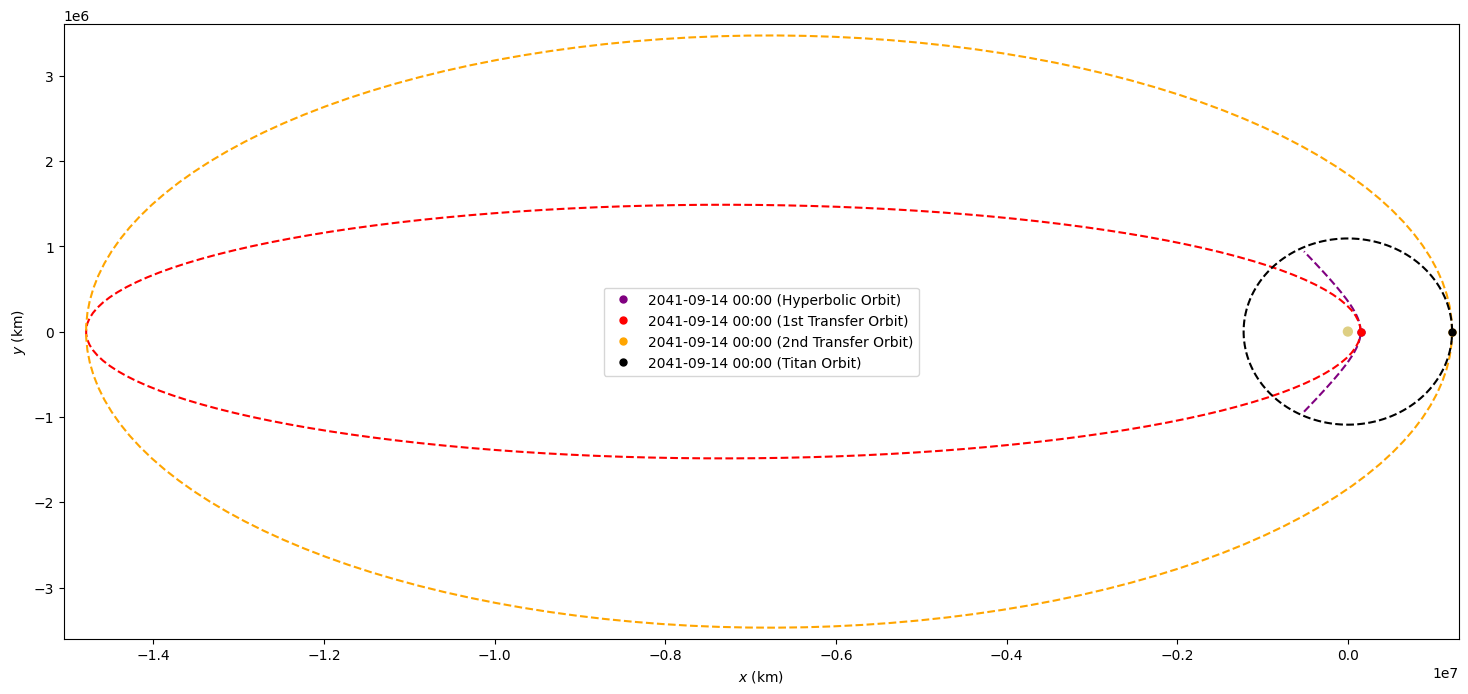

In [6]:
# Define 1st and 2nd orbit
orbit_1 = Orbit.from_classical(Saturn, semi_major_1, e_1, inc_entry, 0 * u.deg, 0 * u.deg, 0 * u.rad, entry_time)
orbit_2 = Orbit.from_classical(Saturn, semi_major_2, e_2, inc_2, 0 * u.deg, 0 * u.deg, 0 * u.rad, entry_time)

# Define Titan orbit
orbit_titan = Orbit.from_classical(Saturn, r_titan_saturn, 0 * u.one, 0. * u.deg, 0 * u.deg, 0 * u.deg, 0 * u.rad, entry_time)

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-15050000, 1300000))
ax.set_ylim((-3600000, 3600000))
plotter = StaticOrbitPlotter(ax)
plotter.plot(orbit_entry, label="Hyperbolic Orbit", color='purple')
plotter.plot(orbit_1, label="1st Transfer Orbit", color='red')
plotter.plot(orbit_2, label="2nd Transfer Orbit", color='orange')
plotter.plot(orbit_titan, label="Titan Orbit", color='black')

# Show plot with legend
ax.legend()
plt.show()

#### 1st Flyby Maneuver around Titan

We assume that the entry at Saturn can be timed in a way that the Titan moon is exactly at the positon of the perigee of the current orbit, when the S/C arrives there.

If this is the case, then the S/C will perform a flyby maneuver around the moon. By choosing the propriate entry angle (also called angle of the B-vector), this flyby can decrease the magnitude of the velocity with respect to the Sun and increase the inclination at the same time. All this is done without applying additonal $\Delta v$.

After theoretical considerations that cannot be illustrated in this notebook, an entry angle of $90\deg$ leads to the desired behaviour. Furthermore, the distance of the flyby needs to be chosen. Therefore, several aspects needs to be considered:
1. As the moon has a radius of about $2500$ km and has an atmosphere of about $600$ km above the surface, we do not want to do a flyby with an minimal distance of less than $3200$ km.
2. As we want to perform multiple consecutive flyby maneuver around Titan, we have to ensure that the orbit period of the next orbit is a multiple of the orbit period of Titan. Otherwise we would not meet Titan on the next perigee and would have to wait until we will luckily meet Titan. The propriate flyby distance of each flyby maneuver is found by simply trying out different values. The orbital period of Titan is about $15.945$ days.


For simulating the flyby, a reference frame is chosen which is centered at Saturn and where the x-axis is pointing to the perigee of the orbits, the y-axis is pointing into the direction of the velocity vector of Titan at the perigee of S/C's orbit and the z-axis is pointing in rotation axis of Saturn.

In [7]:
# Determine timestamp of first flyby
delta_time = orbit_1.period * 0.5 + orbit_2.period * 0.5
flyby_titan_1_time = entry_time + delta_time

# Titan properties
pos_titan_vec = np.array([1, 0, 0]) * r_titan_saturn
v_titan_norm = 5.57 * (u.km / u.s)
v_titan_vec = np.array([0, 1, 0]) * v_titan_norm
titan_grav_const = 8.978 * 10**12 * (u.m**3 / u.s**2)


# ---------- FLYBY TITAN 1 ----------
# Create the velocity vector at perigee of 2nd orbit
v_x = 0
v_y = v_perigee_2 * np.cos(np.deg2rad(inc_2))
v_z = - v_perigee_2 * np.sin(np.deg2rad(inc_2))

v_sc_vec = np.array([v_x, v_y.value, v_z.value]) * (u.km/u.s)

radius_flyby_titan_1 = 4300 * u.km
entry_angle_flyby_titan_1 = 90.0 * u.deg
v_sc_flybyDeparture_1, delta_ = compute_flyby(v_sc_vec, v_titan_vec, titan_grav_const, radius_flyby_titan_1, entry_angle_flyby_titan_1)
orbit_after_flyby_1 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_1, epoch=flyby_titan_1_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_1_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_1}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_1)}")
print(f"\nDistance Perigee of 3rd orbit: \t\t\t{orbit_after_flyby_1.r_p}")
print(f"Distance Apogee of 3rd orbit: \t\t\t{orbit_after_flyby_1.r_a}")
print(f"Inclination of 3rd orbit: \t\t\t{orbit_after_flyby_1.inc.to(u.deg)}")
print(f"Orbit Period of 3rd orbit:\t\t\t{orbit_after_flyby_1.period.to(u.d)}")

Date of Flyby: 					2042-05-26 05:53:32.045

Velocity after Departure: 			[ 3.50817174e-17  3.01349189e+00 -6.49865273e+00] km / s
Velocity after Departure norm: 			7.163352611895739 km / s

Distance Perigee of 3rd orbit: 			1221870.0 km
Distance Apogee of 3rd orbit: 			5819692.128691112 km
Inclination of 3rd orbit: 			65.12236175113038 deg
Orbit Period of 3rd orbit:			78.00569675018983 d


In [8]:
# Check if new orbit period matches the orbit period of Titan
# Result needs to be close 1.0
print(str(orbit_after_flyby_1.period.to(u.d) / (5 * orbit_titan.period.to(u.d))))

0.9782526263143144


#### 2nd Flyby Maneuver at Titan
This process is repeated several times, in order to decrease the current apogee until it changes to the perigee of the orbit and has a distance to Saturn of about $500 000$ km - $600 000$ km and an inclination close to $90 \deg$.

In [9]:
# ---------- FLYBY TITAN 2 ----------
flyby_titan_2_time = flyby_titan_1_time + orbit_after_flyby_1.period

radius_flyby_titan_2 = 5900 * u.km
entry_angle_flyby_titan_2 = 90.0 * u.deg
v_sc_flybyDeparture_2, delta_ = compute_flyby(v_sc_flybyDeparture_1, v_titan_vec, titan_grav_const, radius_flyby_titan_2, entry_angle_flyby_titan_2)
orbit_after_flyby_2 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_2, epoch=flyby_titan_2_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_2_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_2}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_2)}")
print(f"\nDistance Perigee of 4th orbit: \t\t\t{orbit_after_flyby_2.r_p}")
print(f"Distance Apogee of 4th orbit: \t\t\t{orbit_after_flyby_2.r_a}")
print(f"Inclination of 4th orbit: \t\t\t{orbit_after_flyby_2.inc.to(u.deg)}")
print(f"Orbit Period of 4th orbit:\t\t\t{orbit_after_flyby_2.period.to(u.d)}")

# Check if new orbit period matches the orbit period of Titan
# Result needs to be close to 1.0
print()
print(str(orbit_after_flyby_2.period.to(u.d) / (3 * orbit_titan.period.to(u.d))))

Date of Flyby: 					2042-08-12 06:01:44.245

Velocity after Departure: 			[ 6.62776432e-17  2.62507499e+00 -6.33211163e+00] km / s
Velocity after Departure norm: 			6.854681350010971 km / s

Distance Perigee of 4th orbit: 			1221869.9999999998 km
Distance Apogee of 4th orbit: 			3801969.678515079 km
Inclination of 4th orbit: 			67.48279088027672 deg
Orbit Period of 4th orbit:			47.00850662377969 d

0.9825392456291858


#### 3rd Flyby Maneuver at Titan

In [10]:
# ---------- FLYBY TITAN 3 ----------
flyby_titan_3_time = flyby_titan_2_time + orbit_after_flyby_2.period

radius_flyby_titan_3 = 5300 * u.km
entry_angle_flyby_titan_3 = 90.0 * u.deg
v_sc_flybyDeparture_3, delta_ = compute_flyby(v_sc_flybyDeparture_2, v_titan_vec, titan_grav_const, radius_flyby_titan_3, entry_angle_flyby_titan_3)
orbit_after_flyby_3 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_3, epoch=flyby_titan_3_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_3_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_3}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_3)}")
print(f"\nDistance Perigee of 5th orbit: \t\t\t{orbit_after_flyby_3.r_p}")
print(f"Distance Apogee of 5th orbit: \t\t\t{orbit_after_flyby_3.r_a}")
print(f"Inclination of 5th orbit: \t\t\t{orbit_after_flyby_3.inc.to(u.deg)}")
print(f"Orbit Period of 5th orbit:\t\t\t{orbit_after_flyby_3.period.to(u.d)}")

# Check if new orbit period matches the orbit period of Titan
# Result needs to be close to 1.0
print()
print(str(orbit_after_flyby_3.period.to(u.d) / (2 * orbit_titan.period.to(u.d))))

Date of Flyby: 					2042-09-28 06:13:59.217

Velocity after Departure: 			[ 1.04383361e-16  2.20682709e+00 -6.12023602e+00] km / s
Velocity after Departure norm: 			6.505949186622665 km / s

Distance Perigee of 5th orbit: 			1221870.0000000002 km
Distance Apogee of 5th orbit: 			2617366.424419454 km
Inclination of 5th orbit: 			70.17177328762659 deg
Orbit Period of 5th orbit:			31.404369822641176 d

0.9845885793164834


#### 4th Flyby Maneuver at Titan

In [11]:
# ---------- FLYBY TITAN 4 ----------
flyby_titan_4_time = flyby_titan_3_time + orbit_after_flyby_3.period

radius_flyby_titan_4 = 5800 * u.km
entry_angle_flyby_titan_4 = 90.0 * u.deg
v_sc_flybyDeparture_4, delta_ = compute_flyby(v_sc_flybyDeparture_3, v_titan_vec, titan_grav_const, radius_flyby_titan_4, entry_angle_flyby_titan_4)
orbit_after_flyby_4 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_4, epoch=flyby_titan_4_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_4_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_4}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_4)}")
print(f"\nDistance Perigee of 6th orbit: \t\t\t{orbit_after_flyby_4.r_p}")
print(f"Distance Apogee of 6th orbit: \t\t\t{orbit_after_flyby_4.r_a}")
print(f"Inclination of 6th orbit: \t\t\t{orbit_after_flyby_4.inc.to(u.deg)}")
print(f"Orbit Period of 6th orbit:\t\t\t{orbit_after_flyby_4.period.to(u.d)}")

# Check if new orbit period matches the orbit period of Titan
# Result needs to be close to 1.0
print()
print(str((2 * orbit_after_flyby_4.period.to(u.d)) / (3 * orbit_titan.period.to(u.d))))

Date of Flyby: 					2042-10-29 15:56:16.770

Velocity after Departure: 			[ 1.42165528e-16  1.83680426e+00 -5.90181926e+00] km / s
Velocity after Departure norm: 			6.181045259562162 km / s

Distance Perigee of 6th orbit: 			1221870.0 km
Distance Apogee of 6th orbit: 			1954705.851662687 km
Inclination of 6th orbit: 			72.71245882061635 deg
Orbit Period of 6th orbit:			23.635328468548188 d

0.9880185299031801


#### 5th Flyby Maneuver around Titan

In [12]:
# ---------- FLYBY TITAN 5 ----------
flyby_titan_5_time = flyby_titan_4_time + 2 * orbit_after_flyby_4.period

radius_flyby_titan_5 = 3200 * u.km
entry_angle_flyby_titan_5 = 90.0 * u.deg
v_sc_flybyDeparture_5, delta_ = compute_flyby(v_sc_flybyDeparture_4, v_titan_vec, titan_grav_const, radius_flyby_titan_5, entry_angle_flyby_titan_5)
orbit_after_flyby_5 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_5, epoch=flyby_titan_5_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_5_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_5}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_5)}")
print(f"\nDistance Perigee of 7th orbit: \t\t\t{orbit_after_flyby_5.r_p}")
print(f"Distance Apogee of 7th orbit: \t\t\t{orbit_after_flyby_5.r_a}")
print(f"Inclination of 7th orbit: \t\t\t{orbit_after_flyby_5.inc.to(u.deg)}")
print(f"Orbit Period of 7th orbit:\t\t\t{orbit_after_flyby_5.period.to(u.d)}")

# Check if new orbit period matches the orbit period of Titan
# Result needs to be close to 1.0
print()
print(str(orbit_after_flyby_5.period.to(u.d) / orbit_titan.period.to(u.d)))

Date of Flyby: 					2042-12-15 22:26:01.529

Velocity after Departure: 			[ 2.12196091e-16  1.21773125e+00 -5.46131648e+00] km / s
Velocity after Departure norm: 			5.595430917070247 km / s

Distance Perigee of 7th orbit: 			1221870.0000000002 km
Distance Apogee of 7th orbit: 			1242932.4644918933 km
Inclination of 7th orbit: 			77.43015543448377 deg
Orbit Period of 7th orbit:			16.154591348520604 d

1.0129562373075225


#### 6th Flyby Maneuver around Titan

In [13]:
# ---------- FLYBY TITAN 6 ----------
flyby_titan_6_time = flyby_titan_5_time + orbit_after_flyby_5.period

radius_flyby_titan_6 = 3200 * u.km
entry_angle_flyby_titan_6 = 90.0 * u.deg
v_sc_flybyDeparture_6, delta_ = compute_flyby(v_sc_flybyDeparture_5, v_titan_vec, titan_grav_const, radius_flyby_titan_6, entry_angle_flyby_titan_6)
orbit_after_flyby_6 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_6, epoch=flyby_titan_6_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_6_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_6}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_6)}")
print(f"\nDistance Perigee of 8th orbit: \t\t\t{orbit_after_flyby_6.r_p}")
print(f"Distance Apogee of 8th orbit: \t\t\t{orbit_after_flyby_6.r_a}")
print(f"Inclination of 8th orbit: \t\t\t{orbit_after_flyby_6.inc.to(u.deg)}")
print(f"Orbit Period of 8th orbit:\t\t\t{orbit_after_flyby_6.period.to(u.d)}")

# Check if new orbit period matches the orbit period of Titan
# Result needs to be close to 1.0
print()
print(str((3 * orbit_after_flyby_6.period.to(u.d)) / (2 * orbit_titan.period.to(u.d))))

Date of Flyby: 					2043-01-01 02:08:38.221

Velocity after Departure: 			[ 2.86322659e-16  6.50178246e-01 -4.95616534e+00] km / s
Velocity after Departure norm: 			4.99863047837462 km / s

Distance Perigee of 8th orbit: 			822893.0365929686 km
Distance Apogee of 8th orbit: 			1221870.0000000005 km
Inclination of 8th orbit: 			82.52628888655435 deg
Orbit Period of 8th orbit:			12.206390955743974 d

1.1480828812268875


#### 7th Flyby Maneuver around Titan

In [14]:
# ---------- FLYBY TITAN 7 ----------
flyby_titan_7_time = flyby_titan_6_time + 3 * orbit_after_flyby_6.period

radius_flyby_titan_7 = 3200 * u.km
entry_angle_flyby_titan_7 = 90.0 * u.deg
v_sc_flybyDeparture_7, delta_ = compute_flyby(v_sc_flybyDeparture_6, v_titan_vec, titan_grav_const, radius_flyby_titan_7, entry_angle_flyby_titan_7)
orbit_after_flyby_7 = Orbit.from_vectors(Saturn, pos_titan_vec, v_sc_flybyDeparture_7, epoch=flyby_titan_7_time)

print(f"Date of Flyby: \t\t\t\t\t{flyby_titan_7_time}\n")
print(f"Velocity after Departure: \t\t\t{v_sc_flybyDeparture_7}")
print(f"Velocity after Departure norm: \t\t\t{np.linalg.norm(v_sc_flybyDeparture_7)}")
print(f"\nDistance Perigee of 9th orbit: \t\t\t{orbit_after_flyby_7.r_p}")
print(f"Distance Apogee of 9th orbit: \t\t\t{orbit_after_flyby_7.r_a}")
print(f"Inclination of 9th orbit: \t\t\t{orbit_after_flyby_7.inc.to(u.deg)}")
print(f"Orbit Period of 9th orbit:\t\t\t{orbit_after_flyby_7.period.to(u.d)}")

Date of Flyby: 					2043-02-06 17:00:14.757

Velocity after Departure: 			[ 3.62418993e-16  1.40863657e-01 -4.39234557e+00] km / s
Velocity after Departure norm: 			4.394603752816195 km / s

Distance Perigee of 9th orbit: 			551668.8948250709 km
Distance Apogee of 9th orbit: 			1221870.0 km
Inclination of 9th orbit: 			88.16313911289548 deg
Orbit Period of 9th orbit:			9.860157973915019 d


### Getting into the Working Orbit
As can be seen in the results, the orbit could be changed, so that it now has an inclination of almost $90 \deg$ and a perigee of about $555168$ km which lies in the desired range.

Therefore, another $\Delta v_3$ is applied in the new perigee in order to circularize the orbit and change the inclination to $90 \deg$.

In [15]:
last_orbit = orbit_after_flyby_7

desired_inc = 90 * u.deg
delta_inc = desired_inc - last_orbit.inc.to(u.deg)
v_circular_working = np.sqrt(mu / last_orbit.r_p)
v_current_perigee = np.sqrt(mu * ( 2 / last_orbit.r_p - 1 / last_orbit.a))

delta_v_3 = np.sqrt(v_circular_working**2 + v_current_perigee**2 - 2 * v_current_perigee * v_circular_working * np.cos(delta_inc.to(u.rad)))

print(f"\n3rd Delta V applied at perigee:\t\t\t{delta_v_3}")

date_arrival_working_orbit = flyby_titan_7_time + 0.5 * orbit_after_flyby_7.period
print(f"\nDate of arrival in working orbit:\t\t{date_arrival_working_orbit}")



3rd Delta V applied at perigee:			1.46993138886807 km / s

Date of arrival in working orbit:		2043-02-11 15:19:33.582


#### 2D Plot fo the Orbits

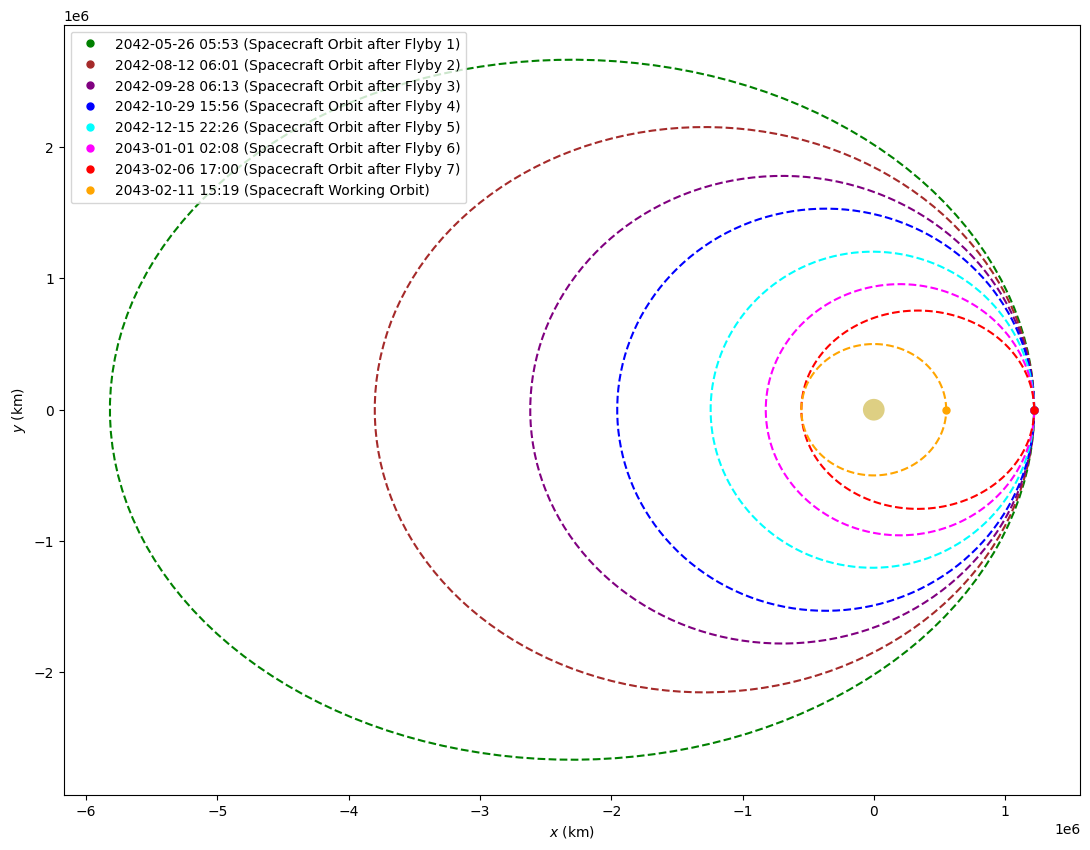

In [16]:
# Define the working trajectory
v_circular_working_vec = np.array([0., 0., -1.]) * v_circular_working
r_circular_working_vec = np.array([1., 0., 0.]) * last_orbit.r_p
orbit_working = Orbit.from_vectors(Saturn, r_circular_working_vec, v_circular_working_vec, epoch=date_arrival_working_orbit)

fig, ax = plt.subplots(figsize=(10, 10))
plotter = StaticOrbitPlotter(ax)

# Plot spacecraft's initial trajectory (Earth to Jupiter)
plotter.plot(orbit_after_flyby_1, label="Spacecraft Orbit after Flyby 1", color='green')
plotter.plot(orbit_after_flyby_2, label="Spacecraft Orbit after Flyby 2", color='brown')
plotter.plot(orbit_after_flyby_3, label="Spacecraft Orbit after Flyby 3", color='purple')
plotter.plot(orbit_after_flyby_4, label="Spacecraft Orbit after Flyby 4", color='blue')
plotter.plot(orbit_after_flyby_5, label="Spacecraft Orbit after Flyby 5", color='cyan')
plotter.plot(orbit_after_flyby_6, label="Spacecraft Orbit after Flyby 6", color='magenta')
plotter.plot(orbit_after_flyby_7, label="Spacecraft Orbit after Flyby 7", color='red')
plotter.plot(orbit_working, label="Spacecraft Working Orbit", color='orange')

# Show plot with legend
ax.legend()
plt.show()

#### 3D Plot of the Orbits

In [17]:
plotter = OrbitPlotter3D()

# Plot spacecraft's initial trajectory (Earth to Jupiter)
plotter.plot(orbit_after_flyby_1, label="Spacecraft Orbit after Flyby 1", color='green')
plotter.plot(orbit_after_flyby_2, label="Spacecraft Orbit after Flyby 2", color='brown')
plotter.plot(orbit_after_flyby_3, label="Spacecraft Orbit after Flyby 3", color='purple')
plotter.plot(orbit_after_flyby_4, label="Spacecraft Orbit after Flyby 4", color='blue')
plotter.plot(orbit_after_flyby_5, label="Spacecraft Orbit after Flyby 5", color='cyan')
plotter.plot(orbit_after_flyby_6, label="Spacecraft Orbit after Flyby 6", color='magenta')
plotter.plot(orbit_after_flyby_7, label="Spacecraft Orbit after Flyby 7", color='red')
plotter.plot(orbit_working, label="Spacecraft Working Orbit", color='orange')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cauto': False,
              'cmax': 1,
              'cmin': 1,
              'colorscale': [[0, '#decf83'], [1, '#decf83']],
              'name': 'Saturn',
              'showscale': False,
              'type': 'surface',
              'x': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                          [ 5.95110811e+04,  5.62866065e+04,  4.69626048e+04, ...,
                            4.69626048e+04,  5.62866065e+04,  5.95110811e+04],
                          [ 1.12573213e+05,  1.06473686e+05,  8.88360827e+04, ...,
                            8.88360827e+04,  1.06473686e+05,  1.12573213e+05],
                          ...,
                          [-1.12573213e+05, -1.06473686e+05, -8.88360827e+04, ...,
                           -8.88360827e+04, -1.06473686e+05, -1.12573213e+05],
                          [-5.95110811e+04, -5.62866065e+04, -4.69626048e+04, ...,
                           -4.69626048e+04, -5.62866065e+04, -5.95110811e+04],
                          [-4.48907755e-11, -4.24584695e-11, -3.54251295e-11, ...,
                           -3.54251295e-11, -4.24584695e-11, -4.48907755e-11]]),
              'y': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                          [ 0.00000000e+00,  1.93232164e+04,  3.65524625e+04, ...,
                           -3.65524625e+04, -1.93232164e+04, -1.45760110e-11],
                          [ 0.00000000e+00,  3.65524625e+04,  6.91438986e+04, ...,
                           -6.91438986e+04, -3.65524625e+04, -2.75724850e-11],
                          ...,
                          [ 0.00000000e+00, -3.65524625e+04, -6.91438986e+04, ...,
                            6.91438986e+04,  3.65524625e+04,  2.75724850e-11],
                          [ 0.00000000e+00, -1.93232164e+04, -3.65524625e+04, ...,
                            3.65524625e+04,  1.93232164e+04,  1.45760110e-11],
                          [ 0.00000000e+00, -1.45760110e-11, -2.75724850e-11, ...,
                            2.75724850e-11,  1.45760110e-11,  1.09950689e-26]]),
              'z': array([[183280.5       , 183280.5       , 183280.5       , ...,
                           183280.5       , 183280.5       , 183280.5       ],
                          [173349.85696751, 173349.85696751, 173349.85696751, ...,
                           173349.85696751, 173349.85696751, 173349.85696751],
                          [144634.06713243, 144634.06713243, 144634.06713243, ...,
                           144634.06713243, 144634.06713243, 144634.06713243],
                          ...,
                          [144634.06713243, 144634.06713243, 144634.06713243, ...,
                           144634.06713243, 144634.06713243, 144634.06713243],
                          [173349.85696751, 173349.85696751, 173349.85696751, ...,
                           173349.85696751, 173349.85696751, 173349.85696751],
                          [183280.5       , 183280.5       , 183280.5       , ...,
                           183280.5       , 183280.5       , 183280.5       ]])},
             {'line': {'color': 'green', 'dash': 'dash', 'width': 5},
              'mode': 'lines',
              'name': '2042-05-26 05:53 (Spacecraft Orbit after Flyby 1)',
              'type': 'scatter3d',
              'x': array([ 1221870.        ,  1218740.08987574,  1209355.92436894,
                           1193734.18818341,  1171902.65619601,  1143900.14407392,
                           1109776.43926179,  1069592.21246149,  1023418.90976185,
                            971338.62561005,   913443.95685075,   849837.83809225,
                            780633.35869254,   705953.56169049,   625931.2250399 ,
                            540708.62553507,   450437.28584789,   355277.70512605,
                         

### Deorbiting the S/C - Crash into Moon Rhea
After the S/C successfully observed the entire surface of the Saturn in the working orbit, we have to ensure that the S/C will be deorbited in a controlled way. This version will use one maneuver which will lead to a controlled crashed of the S/C into the moon Rhea.

Rhea orbits Saturn in a circular orbit with a radius that is very close to our working trajectory. Thus, only a small $\Delta v$ is required to change the circular working orbit into an elliptical orbit that has a perigee at the same distance as the radius of Rhea's orbit.

In [18]:
r_rhea_saturn = 527040 * u.km
semi_major_transfer = (last_orbit.r_p + r_rhea_saturn) / 2.
v_apogee_transfer = np.sqrt(mu * ( (2 / (last_orbit.r_p)) - (1 / semi_major_transfer)))

delta_v_4 = np.abs(v_circular_working - v_apogee_transfer)

print(f"\n4th Delta V applied at perigee:\t\t\t{delta_v_4}")


4th Delta V applied at perigee:			0.09520728639502352 km / s


## $\Delta v$ Budget

If we consider all the $\Delta v$ that needs to be applied for the shown maneuver, we result in a total $\Delta v_{total}$ of:

In [19]:
delta_v_total = delta_v_1 + delta_v_2 + delta_v_3 + delta_v_4
print(delta_v_total)

4.234710409005846 km / s


As many precise flyby maneuvers have to be carried out and an adjustment of impact parameter of the hyperbolic entry orbit needs to be performed, some additional margins have to be considered. We assume that a margin of about $0.5$ km/s should be enough. This yields a final $\Delta v_{final}$ of:

In [20]:
delta_v_margin = 0.5 * u.km / u.s
delta_v_final = delta_v_total + delta_v_margin
print(delta_v_final)

4.734710409005846 km / s
